In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import PatchTSTConfig, PatchTSTForPrediction
import torch.optim as optim

## 데이터 로드

Read IBM stock OHLC ( open, high, low, close) and S&P 500 bid/ask df. df into pandas dfframe.

In [16]:
stock=pd.read_csv('삼성전자주가(20220406-20240405).csv')
df=stock.copy()

In [17]:
class Mymodel(nn.Module):
    def __init__(self, model):
        super(Mymodel, self).__init__()
        self.patch_tst = model
        self.fc=nn.Linear(model.config.num_input_channels, 1)
        # 가정: PatchTSTForPrediction의 출력 차원이 config.output_dim으로 주어짐

    def forward(self, x):
        # PatchTST 모델을 통과시킨 후의 출력
        x = self.patch_tst(past_values=x).prediction_outputs
        # 완전연결 계층을 통과시켜 최종 출력을 얻음
        x = self.fc(x)
        return x

In [18]:
class Stock:
    def __init__(self, df):
        super(Stock, self).__init__()
        self.df=df.copy()
        self.scaler_all = MinMaxScaler(feature_range=(0,1))
        self.scaler_target = MinMaxScaler(feature_range=(0,1))
        self.data=df.values
        self.predictions = []  # 예측값을 저장할 리스트
        self.actuals = []  # 실제값을 저장할 리스트
        self.train_losses = []
        self.val_losses = []

    def preprocessing(self):
        # index를 날짜로 설정
        self.df["Datetime"] = pd.to_datetime(self.df["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
        self.df['Datetime'] = pd.to_datetime(self.df['Datetime'])
        self.df.set_index('Datetime', inplace=True)        
        self.df.drop('Adj Close', axis=1, inplace=True)
        return self.df

    def add_change(self, columns):
        for col in columns:
            self.df[f'{col}_chg']=self.df[col].pct_change()
        self.df.dropna(inplace=True)
        return self.df

    
    def add_col(self):
        self.df['O-C'] = self.df['Open'] - self.df['Close']
        self.df['H-L'] = self.df['High'] - self.df['Low']
        self.df['2Hr_MA'] = self.df['Close'].rolling(window=2).mean()
        self.df['4Hr_MA'] = self.df['Close'].rolling(window=4).mean()
        self.df['6Hr_MA'] = self.df['Close'].rolling(window=6).mean()
        self.df['12Hr_MA'] = self.df['Close'].rolling(window=12).mean()
        self.df['18Hr_MA'] = self.df['Close'].rolling(window=18).mean() 
        self.df['2Hr_Std'] = self.df['Close'].rolling(window = 4).std()
        self.df.dropna(inplace=True)
        return self.df

    def scale_col(self, selected_feature):
        self.selected_feature=selected_feature
        data=self.df[selected_feature].values
        self.data = self.scaler_all.fit_transform(data)
        self.scaler_target.fit_transform(data[:,0].reshape(1,-1))
        self.scaler_target.min_, self.scaler_target.scale_ = self.scaler_all.min_[0], self.scaler_all.scale_[0]


    def create_sequences(self, data, seq_length):
        xs, ys = [], []
        for i in range(len(data)-seq_length):
            x = data[i:(i+seq_length), ]
            y = data[i+seq_length, 0]  # 예측하려는 값을 0에 배치
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    def data_loader(self, seq_len, type='train'):
        self.seq_len=seq_len
        train_size = int(len(self.data) * 0.7)
        val_size = int(len(self.data) * 0.2)
        test_size = len(self.data) - train_size - val_size
        self.train_losses=[]
        self.val_losses=[]

        if type=='train':
            X, y = self.create_sequences(self.data[:train_size], seq_len)
        elif type=='valid':
            X, y = self.create_sequences(self.data[train_size:train_size+val_size], seq_len)
        elif type=='test':
            X, y = self.create_sequences(self.data[train_size+val_size:], seq_len)
        else:
            X, y = self.create_sequences(self.data, seq_len)
                
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        data = TensorDataset(X, y)
        data_loader = DataLoader(dataset=data, batch_size=16, shuffle=False)

        return data_loader
    
    def create_model(self, pred_length=1, d=0.3):
        configuration = PatchTSTConfig(prediction_length=pred_length, context_length=self.seq_len, num_input_channels=len(self.selected_feature), drop_out=d)
        self.patch = PatchTSTForPrediction(configuration)
        self.fc = nn.Linear(self.patch.config.num_input_channels, 1)
        self.model=Mymodel(self.patch) # 모델 정의
    
    def train(self, train_loader, val_loader, test_loader, patience, lr, epoch, type, min_delta=0.00001):
        self.patience = patience  # 검증 손실이 개선되지 않는 에포크 허용 횟수
        self.min_delta = min_delta  # 개선으로 간주되기 위한 최소 변화량
        best_loss = np.inf  # 가장 낮은 검증 손실을 추적
        last_val_loss = np.inf
        patience_counter = 0  # 개선되지 않는 에포크를 세는 카운터

        # 손실 함수와 최적화 알고리즘 설정
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # 학습 과정
        epochs = epoch
        k=0.5
        if type=='train':
            for epoch in range(epochs):
                self.model.train()  # 모델을 훈련 모드로 설정
                train_loss = 0.0

                for seqs, labels in train_loader:
                    optimizer.zero_grad()  # 그래디언트 초기화
                    outputs = self.model.forward(seqs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()  # 최적화 알고리즘을 통한 파라미터 업데이트
                    
                    train_loss += loss.item() * seqs.size(0)
                
                train_loss /= len(train_loader.dataset)
                self.train_losses.append(train_loss)

                self.model.eval()  # 모델을 평가 모드로 설정
                val_loss = 0.0

                with torch.no_grad():
                    self.model.eval()
                    for seqs, labels in val_loader:
                        outputs = self.model.forward(seqs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item() * seqs.size(0)  # 누적 손실 계산

                # 에포크별 평균 검증 손실 계산
                val_loss /= len(val_loader.dataset)
                self.val_losses.append(val_loss)

                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

                if val_loss < best_loss:
                    best_loss=val_loss

                if train_loss*1.4 < val_loss - min_delta:
                    patience_counter = 0
                else:
                    patience_counter += 1
                    print(f'Learning rate {patience_counter} of {patience}')

                last_val_loss = val_loss  # 마지막 검증 손실 업데이트

                if patience_counter >= patience:
                    print(f'Learning rate: {0.001*k}')
                    optimizer = optim.Adam(self.model.parameters(), lr=0.001*k)
                    k*=0.5
                    patience_counter=0

            print(f'best loss: {best_loss}')

        if type=='test':
            self.predictions=[]
            self.actuals=[]
            self.model.eval()  # 모델을 평가 모드로 설정
            test_losses = []  # 테스트 손실을 저장할 리스트

            with torch.no_grad():  # 기울기 계산을 비활성화
                for seqs, labels in test_loader:

                    outputs = self.model(seqs)

                    # 손실 계산
                    loss = criterion(outputs, labels)
                    test_losses.append(loss.item())

                    # 예측값과 실제값 저장
                    self.predictions.extend(outputs.view(-1).detach().numpy())
                    self.actuals.extend(labels.view(-1).detach().numpy())

            # 평균 테스트 손실 계산 및 출력
            average_test_loss = sum(test_losses) / len(test_losses)
            print(f'Average Test Loss: {average_test_loss}')

    def pred_value(self, type):
        if (type=='chg')|(type=='t'):
            train_size = int(len(self.data) * 0.7)
            val_size = int(len(self.data) * 0.2)
            if type=='t':
                yest=self.df.iloc[4:,3].values.reshape(-1,1)
            else:
                yest=self.df.iloc[train_size+val_size+4:,3].values.reshape(-1,1)
            self.predictions_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.predictions).reshape(-1,1))*yest+yest, -2)
            self.actuals_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.actuals).reshape(-1,1))*yest+yest, -2)
        else:
            self.predictions_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.predictions).reshape(-1,1)), -2)
            self.actuals_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.actuals).reshape(-1,1)), -2)
        return self.predictions_inverse, self.actuals_inverse
    
    def diff(self):
        differences = [abs(pred - actual) for pred, actual in zip(self.predictions_inverse, self.actuals_inverse)]
        print("최대 : " , max(differences) ,"최소 : " , min(differences) ,"평균: " , sum(differences) / len(differences))

    def loss(self):
        # 훈련 손실과 검증 손실을 에포크별로 그래프로 그리기
        plt.figure(figsize=(10, 6))  # 그래프 크기 설정
        plt.plot(self.train_losses, label='Training Loss', marker='o')  # 훈련 손실 그래프
        plt.plot(self.val_losses, label='Validation Loss', marker='x')  # 검증 손실 그래프
        plt.title('Training and Validation Loss')  # 그래프 제목
        plt.xlabel('Epochs')  # x축 라벨
        plt.ylabel('Loss')  # y축 라벨
        plt.legend()  # 범례 표시
        plt.grid(True)  # 그리드 표시
        plt.show()  # 그래프 보여주기
    
    
    def show(self, type):
        if type=='chg':
            predictions_inverse=self.predictions_inverse[1:]
            actuals_inverse=self.actuals_inverse[1:]

        else:
            predictions_inverse=self.predictions_inverse
            actuals_inverse=self.actuals_inverse

        n = 60
        num_plots = len(predictions_inverse) // n
        if len(predictions_inverse) % n != 0:
            num_plots += 1

        # Plot 생성
        fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6*num_plots))

        for i in range(num_plots):
            start_index = i * n
            end_index = min((i + 1) * n, len(predictions_inverse))
            
            # Subplot 생성
            ax = axes[i] if num_plots > 1 else axes
            
            # 예측값과 실제값 그리기
            ax.plot(predictions_inverse[start_index:end_index], label='Predictions')
            ax.plot(actuals_inverse[start_index:end_index], label='Actuals')
            ax.set_title(f'Predictions vs Actuals (Subset {i+1})')
            ax.set_xlabel('Index')
            ax.set_ylabel('Values')
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

In [19]:
stock=Stock(df)

In [20]:
stock.preprocessing()

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,1846582
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,901392
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,2053045
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,924688
...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,3548675
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,1732644
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,1052082


In [21]:
stock.add_change(stock.df.columns)

,Open,High,Low,Close,Volume,Open_chg,High_chg,Low_chg,Close_chg,Volume_chg
Datetime,,,,,,,,,,
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,1846582,0.000000,0.000000,0.000000,0.000000,inf
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,901392,0.001458,-0.001453,0.000000,-0.001456,-0.511859
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,2053045,0.000000,0.000000,-0.001458,0.000000,1.277638
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,924688,-0.001456,-0.001456,0.000000,0.000000,-0.549602
2022-04-06 14:00:00,68600.0,68700.0,68500.0,68500.0,2004197,0.000000,0.001458,0.000000,-0.001458,1.167431
...,...,...,...,...,...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,3548675,0.002367,-0.002353,0.000000,-0.008264,-0.562848
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,1732644,-0.009445,-0.005896,0.001193,0.002381,-0.511749
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,1052082,0.004768,0.002372,0.002384,0.002375,-0.392788


In [22]:
stock.df.loc[stock.df['Volume_chg']==np.inf,'Volume_chg']=0

In [23]:
stock.scale_col(stock.df.columns[[3,0,1,2,4]]) # 종가
# stock.scale_col(stock.df.columns[[8,5,6,7,9]]) # 종가(변화율)

In [24]:
train_loader=stock.data_loader(4, 'train')

In [25]:
valid_loader=stock.data_loader(4, 'valid')

In [26]:
test_loader=stock.data_loader(4, 'test')

In [27]:
stock.create_model(1, 0.2)

In [28]:
stock.train(train_loader, valid_loader, test_loader, 5, 0.001, 10, 'train')

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

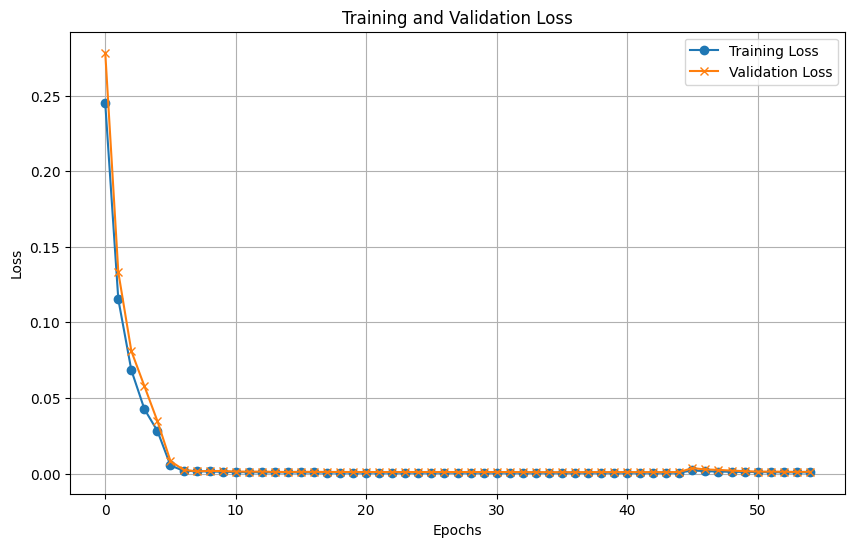

In [ ]:
stock.loss()

In [ ]:
stock.model.load_state_dict(torch.load('close.pth'))
stock.model.load_state_dict(torch.load('chg_close.pth'))

<All keys matched successfully>

In [ ]:
stock.train(train_loader, valid_loader, test_loader, 7, 0.001, 80, 'test')

c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.0029287357587906484


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
pred, act=stock.pred_value('origin')

In [ ]:
stock.diff()

최대 :  [5400.] 최소 :  [0.] 평균:  [1273.0376]


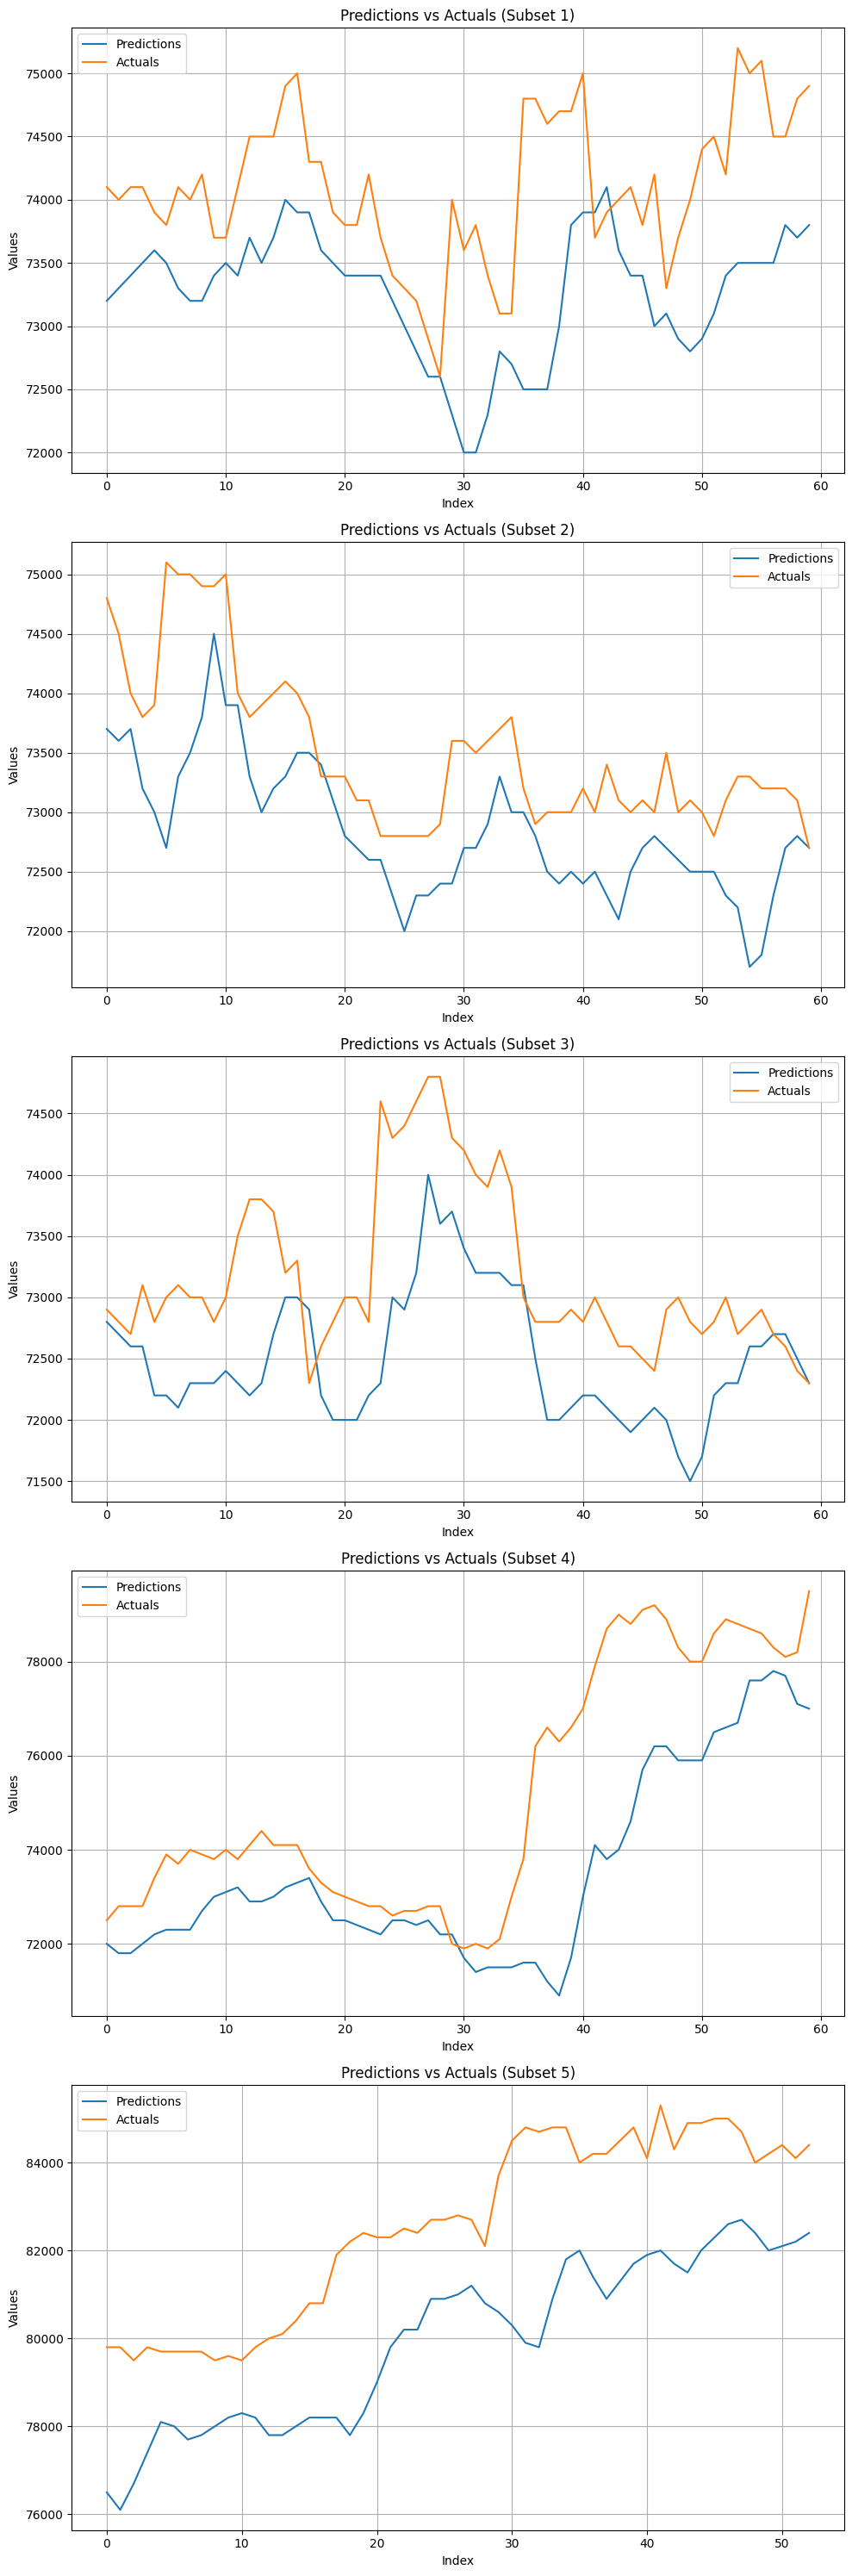

In [ ]:
stock.show('origin')

In [ ]:
((pred-stock.df.iloc[int(len(stock.data)*0.9)+3:,3].values.reshape(-1,1))*(act-stock.df.iloc[int(len(stock.data)*0.9)+3:,3].values.reshape(-1,1))==0).sum()

105

In [ ]:
'''
import itertools

# 실험할 하이퍼파라미터 조합 정의
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
hidden_sizes = [64, 128, 256]
seq_len = [6, 12, 24, 48]
drop_out=[0.1, 0.2, 0.5]

# 가능한 모든 하이퍼파라미터 조합 생성
hyperparameter_combinations = list(itertools.product(learning_rates, batch_sizes, hidden_sizes, seq_len))

best_val_loss = np.inf
best_hyperparameters = None

# 각 하이퍼파라미터 조합에 대해 그리드 서치 실행
for lr, batch_size, hidden_size, seq_len in hyperparameter_combinations:

    # DataLoader 설정
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)

    val_data = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

    # 모델 설정 변경
    # 일단은 통합적으로 생성
    class configs:
        seq_len = seq_len
        pred_len = 1
        enc_in = 6  # 입력 채널을 5로 변경 (시가, 고가, 저가, 종가, 거래량)
        individual = False
    
    # 모델 생성
    configuration = PatchTSTConfig(prediction_length=1, context_length=seq_len, num_input_channels=6, drop_out=drop_out, hidden_size=hidden_size)

    model = PatchTSTForPrediction(configuration)
    
    # 모델 학습 및 검증
    patience = 25  # 검증 손실이 개선되지 않는 에포크 허용 횟수
    min_delta = 0.00001  # 개선으로 간주되기 위한 최소 변화량
    best_loss = np.inf  # 가장 낮은 검증 손실을 추적dd
    last_val_loss = np.inf
    patience_counter = 0  # 개선되지 않는 에포크를 세는 카운터

    # 손실 함수와 최적화 알고리즘 설정
    criterion = RMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)



    # 학습 과정
    epochs = 100

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # 모델을 훈련 모드로 설정
        train_loss = 0.0

        for seqs, labels in train_loader:
            optimizer.zero_grad()  # 그래디언트 초기화
            outputs = model(
                past_values=seqs
            )
            loss = criterion(outputs.prediction_outputs[:,:,3], labels)
            loss.backward()
            optimizer.step()  # 최적화 알고리즘을 통한 파라미터 업데이트

            train_loss += loss.item() * seqs.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()  # 모델을 평가 모드로 설정
        val_loss = 0.0

        with torch.no_grad():
            model.eval()
            for seqs, labels in val_loader:
                outputs = model(
                    past_values=seqs
                )
                loss = criterion(outputs.prediction_outputs[:,:,3], labels)
                val_loss += loss.item() * seqs.size(0)  # 누적 손실 계산

        # 에포크별 평균 검증 손실 계산
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')

        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'Early Stopping Counter {patience_counter} of {patience}')

        last_val_loss = val_loss  # 마지막 검증 손실 업데이트

        if patience_counter >= patience:
            print("Early stopping initiated.")
            print(f"Best Validation Loss: {best_loss:.5f}")
            break
    
    # 검증 성능 평가
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparameters = (lr, batch_size, hidden_size)

print("Best Validation Loss:", best_val_loss)
print("Best Hyperparameters:", best_hyperparameters)
'''

'\nimport itertools\n\n# 실험할 하이퍼파라미터 조합 정의\nlearning_rates = [0.001, 0.01, 0.1]\nbatch_sizes = [16, 32, 64]\nhidden_sizes = [64, 128, 256]\nseq_len = [6, 12, 24, 48]\ndrop_out=[0.1, 0.2, 0.5]\n\n# 가능한 모든 하이퍼파라미터 조합 생성\nhyperparameter_combinations = list(itertools.product(learning_rates, batch_sizes, hidden_sizes, seq_len))\n\nbest_val_loss = np.inf\nbest_hyperparameters = None\n\n# 각 하이퍼파라미터 조합에 대해 그리드 서치 실행\nfor lr, batch_size, hidden_size, seq_len in hyperparameter_combinations:\n\n    # DataLoader 설정\n    train_data = TensorDataset(X_train_tensor, y_train_tensor)\n    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)\n\n    val_data = TensorDataset(X_val_tensor, y_val_tensor)\n    val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)\n\n    # 모델 설정 변경\n    # 일단은 통합적으로 생성\n    class configs:\n        seq_len = seq_len\n        pred_len = 1\n        enc_in = 6  # 입력 채널을 5로 변경 (시가, 고가, 저가, 종가, 거래량)\n        individual = False\

In [ ]:
# torch.save(stock.model.state_dict(), 'close.pth')
torch.save(stock.model.state_dict(), 'chg_close.pth')

수익률계산

In [517]:
name='almac'

In [518]:
if name=='삼성':
    df_get=pd.read_csv('samsung_m.csv')
    df_pred=pd.read_csv('samsung_h.csv')
if name=='SK':
    df_get=pd.read_csv('hynix_m.csv')
    df_pred=pd.read_csv('hynix_h.csv')
if name=='almac':
    df_get=pd.read_csv('almac_m.csv')
    df_pred=pd.read_csv('almac_h.csv')

모델 학습

In [519]:
stock.df=df_pred.copy()

In [520]:
df_pred=stock.preprocessing()

In [521]:
stock.add_change(stock.df.columns)

,Open,High,Low,Close,Volume,Open_chg,High_chg,Low_chg,Close_chg,Volume_chg
Datetime,,,,,,,,,,
2024-04-17 10:00:00,34750.0,34800.0,34300.0,34750.0,3833.0,0.019062,-0.011364,0.005865,0.000000,-0.444444
2024-04-17 11:00:00,34700.0,36000.0,34700.0,34950.0,8295.0,-0.001439,0.034483,0.011662,0.005755,1.164101
2024-04-17 12:00:00,34950.0,35800.0,34900.0,35450.0,1617.0,0.007205,-0.005556,0.005764,0.014306,-0.805063
2024-04-17 13:00:00,35400.0,36300.0,35350.0,36250.0,5465.0,0.012876,0.013966,0.012894,0.022567,2.379716
2024-04-17 14:00:00,36250.0,37800.0,35950.0,36550.0,23416.0,0.024011,0.041322,0.016973,0.008276,3.284721
...,...,...,...,...,...,...,...,...,...,...
2024-05-03 10:00:00,42100.0,47150.0,41700.0,45050.0,795898.0,0.122667,0.108108,0.112000,0.068802,3.716097
2024-05-03 11:00:00,45000.0,48200.0,44600.0,47400.0,440130.0,0.068884,0.022269,0.069544,0.052164,-0.447002
2024-05-03 12:00:00,47350.0,47800.0,46550.0,47350.0,164348.0,0.052222,-0.008299,0.043722,-0.001055,-0.626592


In [522]:
stock.df.loc[stock.df['Volume_chg']==np.inf,'Volume_chg']=0

In [523]:
# stock.scale_col(stock.df.columns[[3,0,1,2,4]]) # 종가
stock.scale_col(stock.df.columns[[8,5,6,7,9]]) # 종가(변화율)

In [524]:
#stock.scale_col(stock.df.columns[[3,0,1,2,4]])

In [525]:
test_loader=stock.data_loader(4, 't')

In [526]:
stock.create_model()

In [527]:
# stock.model.load_state_dict(torch.load('close.pth'))
stock.model.load_state_dict(torch.load('chg_close.pth'))

<All keys matched successfully>

In [528]:
stock.train(train_loader, valid_loader, test_loader, 7, 0.001, 80, 'test')

Average Test Loss: 0.11476372014731169


c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\horri\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [529]:
pred, act=stock.pred_value('t')

In [530]:
stock.diff()

최대 :  [6300.] 최소 :  [0.] 평균:  [911.94029851]


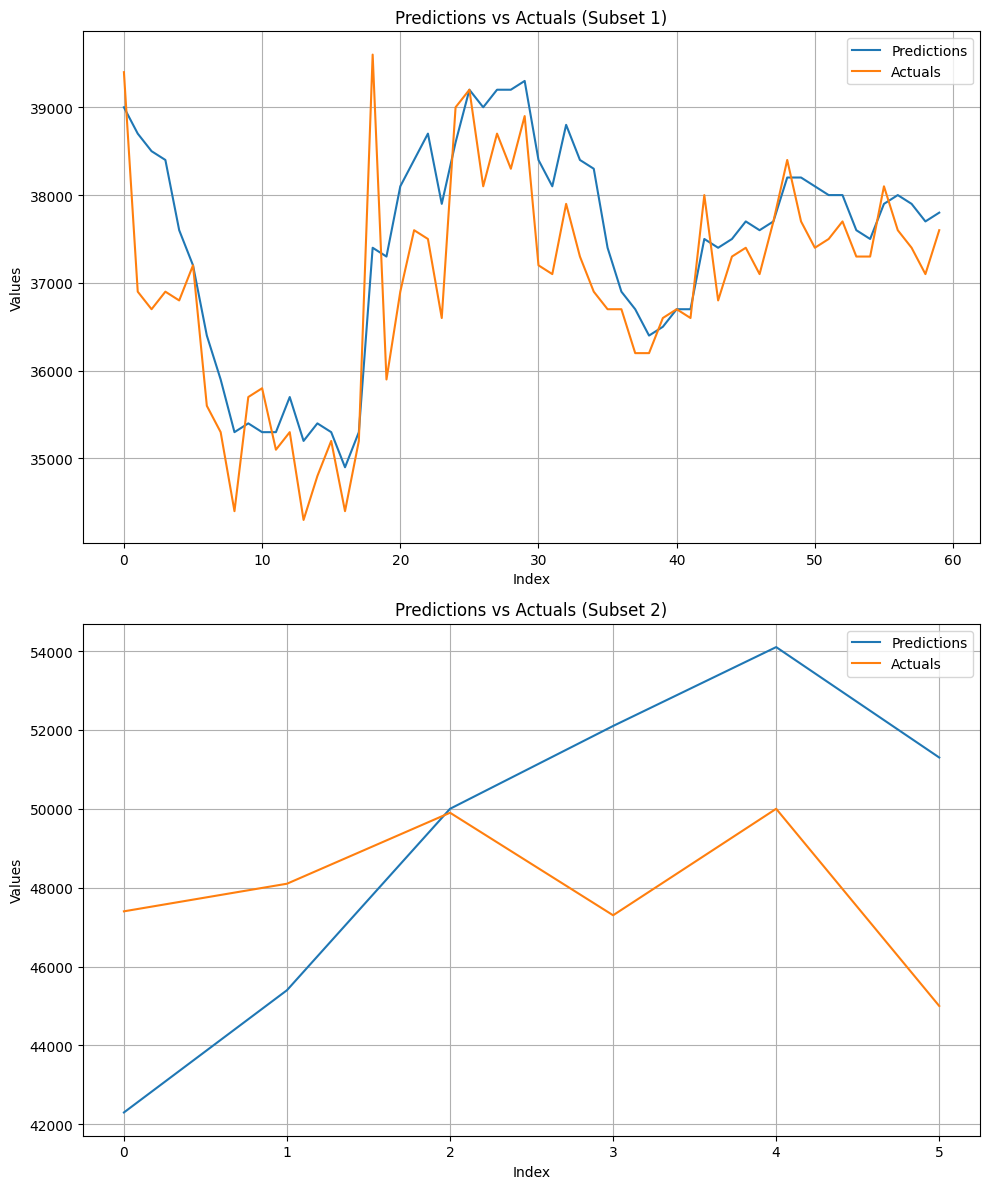

In [531]:
stock.show('chg')

데이터셋 예측값 합치기

In [532]:
stock.df=df_get.copy()
df_get=stock.preprocessing()

In [533]:
df_pred['pred']=0

In [534]:
df_pred.iloc[len(df_pred)-len(pred):,-1]=pred

In [535]:
df_get['key']=pd.to_datetime(df_get.index).strftime('%m-%H')
df_pred['key']=pd.to_datetime(df_pred.index).strftime('%m-%H')

In [536]:
df_get.loc[:,'pred']=pd.merge(df_get[['key']], df_pred[['key', 'pred']], how='left', on='Datetime')['pred']
df_get.fillna(method='ffill', inplace=True)

C:\Users\horri\AppData\Local\Temp\ipykernel_32572\432936643.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_get.fillna(method='ffill', inplace=True)


In [537]:
df_get[pd.to_datetime(df_get.index).strftime('%M')=='00']

,Open,High,Low,Close,Volume,key,pred
Datetime,,,,,,,
2024-04-24 09:00:00,37600.0,38000.0,37550.0,38000.0,2244.6,04-09,38600.0
2024-04-24 10:00:00,37950.0,37950.0,37900.0,37900.0,128.0,04-10,39200.0
2024-04-24 11:00:00,38550.0,38600.0,38450.0,38450.0,1532.0,04-11,39000.0
2024-04-24 12:00:00,38250.0,38250.0,38250.0,38250.0,61.0,04-12,39200.0
2024-04-24 14:00:00,38400.0,38400.0,38400.0,38400.0,6.0,04-14,39300.0
2024-04-25 09:00:00,39350.0,39450.0,38700.0,39350.0,4412.0,04-09,38400.0
2024-04-25 10:00:00,37900.0,37900.0,37750.0,37750.0,40.0,04-10,38100.0
2024-04-25 11:00:00,37500.0,37500.0,37500.0,37500.0,50.4,04-11,38800.0
2024-04-25 12:00:00,37650.0,37650.0,37650.0,37650.0,93.6,04-12,38400.0


이평선

In [651]:
df_get['4H_MA'] = df_get['Close'].rolling(window=12).mean()
df_get['8H_MA'] = df_get['Close'].rolling(window=18).mean()

In [652]:
# 이전 행의 4H_MA와 8H_MA 비교를 위해 shift() 사용
df_get['Previous_4H_MA'] = df_get['4H_MA'].shift(1)
df_get['Previous_8H_MA'] = df_get['8H_MA'].shift(1)

# 매수 조건: 이전 4H_MA <= 이전 8H_MA 이고 현재 4H_MA > 현재 8H_MA
df_get['Buy_Signal'] = (df_get['Previous_4H_MA'] <= df_get['Previous_8H_MA']) & (df_get['4H_MA'] > df_get['8H_MA'])

# 매도 조건: 각 시간대의 마지막 분(59분)에 매도
# df_get['Sell_Signal'] = pd.to_datetime(df_get.index).minute == 59
df_get['Sell_Signal'] = (df_get['Previous_4H_MA'] >= df_get['Previous_8H_MA']) & (df_get['4H_MA'] < df_get['8H_MA'])

In [653]:
results=[]
moneys=[]
money=[]
first=[]
key=False
for i, row in df_get.iterrows():
    if row['Buy_Signal'] and row['Open']<=row['pred']:
        money.append(row['Open'])
        key=True
    if (row['Sell_Signal'] or row['Open']>row['pred']) and key:
        results.append((row['Close']-money[0])/money[0]*100)
        moneys.append(row['Close']-money[0])
        first.append(money[0])
        money=[]
        key=False

In [654]:
print(f'모델 수익률: {round(sum(moneys)/first[0]*100, 3)}%')
print(f'모델 수익: {int(sum(moneys))}')
print(f'수수료 포함 수익률: {round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)}%')
print(f'buy & hold 수익률: {round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)}%')
print(f'buy & hold 수익: {int(df_get.iloc[-1,3]-df_get.iloc[0,0])}')
print(f'매매횟수: {len(moneys)}')

모델 수익률: 25.794%
모델 수익: 9750
수수료 포함 수익률: 14.994%
buy & hold 수익률: 24.468%
buy & hold 수익: 9200
매매횟수: 54


변동성

In [618]:
df_pred['Point']=(df_pred['High'].shift(1)-df_pred['Low'].shift(1))*k+df_pred['Open']
df_pred['Point2']=-(df_pred['High'].shift(1)-df_pred['Low'].shift(1))*k+df_pred['Open']
df_get['Point']=pd.merge(df_get[['key']], df_pred[['key', 'Point']], how='left', on='Datetime')['Point']
df_get['Point2']=pd.merge(df_get[['key']], df_pred[['key', 'Point2']], how='left', on='Datetime')['Point2']
df_get['Point'].fillna(method='ffill', inplace=True)
df_get['Point2'].fillna(method='ffill', inplace=True)

C:\Users\horri\AppData\Local\Temp\ipykernel_32572\4259674038.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_get['Point'].fillna(method='ffill', inplace=True)
C:\Users\horri\AppData\Local\Temp\ipykernel_32572\4259674038.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_get['Point2'].fillna(method='ffill', inplace=True)


In [619]:
df_get['Buy_Signal'] = (df_get['Point'] <= df_get['Open'])
df_get['Sell_Signal'] = (df_get['Point2'] >= df_get['Open'])
# df_get['Sell_Signal'] = pd.to_datetime(df_get.index).minute == 59

In [620]:
moneys=[]
money=[]
first=[]
key=False
for i, row in df_get.iterrows():
    if row['Buy_Signal'] and row['Open']<=row['pred']:
        money.append(row['Open'])
        key=True
    if (row['Sell_Signal'] or row['Open']>row['pred']) and key:
        moneys.append(row['Close']-money[0])
        first.append(money[0])
        money=[]
        key=False

In [621]:
print(f'모델 수익률: {round(sum(moneys)/first[0]*100, 3)}%')
print(f'모델 수익: {int(sum(moneys))}')
print(f'수수료 포함 수익률: {round(sum(moneys)/first[0]*100-len(moneys)*0.2,3)}%')
print(f'buy & hold 수익률: {round((df_get.iloc[-1,3]-df_get.iloc[0,0])/df_get.iloc[0,0]*100, 3)}%')
print(f'buy & hold 수익: {int(df_get.iloc[-1,3]-df_get.iloc[0,0])}')
print(f'매매횟수: {len(moneys)}')

모델 수익률: 18.926%
모델 수익: 7050
수수료 포함 수익률: 18.526%
buy & hold 수익률: 24.468%
buy & hold 수익: 9200
매매횟수: 2
